In [1]:
#from sinf.fid_score import evaluate_fid_score
import numpy as np
import torch
import os

In [3]:
path_images = "cifar10_train.npz"

In [4]:
images_data = np.load(path_images)["data"]
labels_data = np.load(path_images)["labels"]
#images_data = images_data.astype(np.float32) / 127.5 - 1
#images_data =  np.transpose(images_data, [0, 3, 1, 2])

In [5]:
#images_data = 2*images_data -1

In [ ]:
images_data0_9 = []
for i in range(10):
    for img in images_data[labels_data == i]:
        images_data0_9.append(img)  
        break
images_data0_9 = np.array(images_data0_9)

In [7]:
images_data0_9.shape

(10, 3, 32, 32)

In [ ]:
import matplotlib.pyplot as plt

def plot_image_row(images, labels=None, ncols=10, figsize=(15, 2),
                   cmap='gray', normalize=True):
    """
    Plot a row of images side by side (supports single-channel or three-channel images).
    Floating-point images are automatically normalized to [0, 1],
    while integer images are clipped to [0, 255].

    Args:
        images (Tensor or np.ndarray):
            - If Tensor: shape = (N, C, H, W) or (N, H, W, C)
            - If ndarray: shape = (N, C, H, W) or (N, H, W, C)
        labels (list of str or int, optional): Title for each image.
        ncols (int): Number of columns to display (min(N, ncols)).
        figsize (tuple): Figure size.
        cmap (str): Colormap for single-channel images.
        normalize (bool): Whether to normalize floating-point images to [0, 1].

    Example:
        plot_image_row(images, labels=list(range(10)), normalize=True)
    """
    # Convert Tensor to numpy array
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()

    N = images.shape[0]
    ncols = min(ncols, N)
    fig, axes = plt.subplots(1, ncols, figsize=figsize)

    for i in range(ncols):
        ax = axes[i]
        img = np.squeeze(images[i])

        # (C, H, W) -> (H, W, C)
        if img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.transpose(1, 2, 0)

        # Normalization / clipping
        if img.dtype == np.float32 or img.dtype == np.float64:
            if normalize:
                mn, mx = img.min(), img.max()
                # Avoid division by zero
                if mx > mn:
                    img = (img - mn) / (mx - mn)
                else:
                    img = np.clip(img, 0, 1)
            else:
                img = np.clip(img, 0.0, 1.0)
        else:
            # Clip integer images and convert to uint8
            img = np.clip(img, 0, 255).astype(np.uint8)

        # Plot image
        if img.ndim == 2:
            ax.imshow(img, cmap=cmap)
        else:
            ax.imshow(img)
        if labels is not None:
            ax.set_title(f'{labels[i]}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


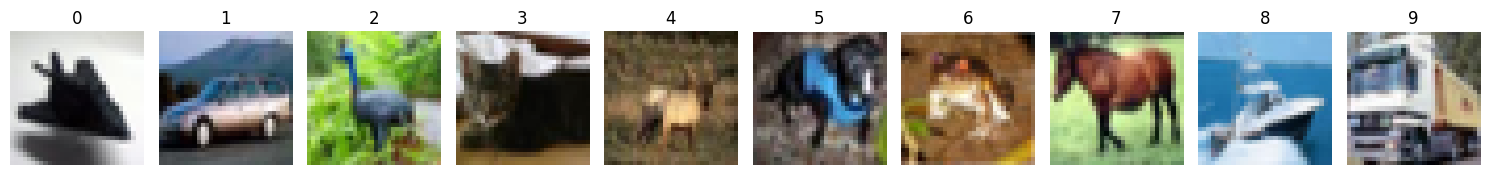

In [9]:
plot_image_row(images_data0_9, labels=list(range(10)), ncols=10, figsize=(15,2))

In [10]:
images_data.shape

(50000, 3, 32, 32)

In [11]:
path_generated = "generated_images_y.npz"

In [12]:
data_full = np.load(path_generated)
samples_full = data_full['images']
labels_full = data_full['labels']

In [ ]:
full_samples = []
for i in range(10):
    for img in samples_full[labels_full == i]:
        full_samples.append(img)  
        break
full_samples = np.stack(full_samples)

In [14]:
full_samples.shape

(10, 3, 32, 32)

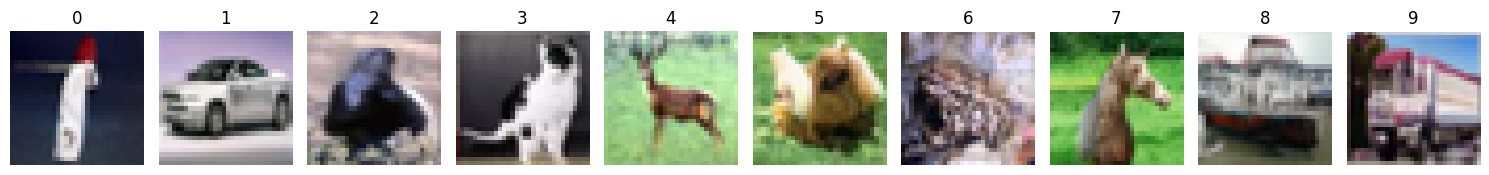

In [15]:
plot_image_row(full_samples, labels=list(range(10)), ncols=10, figsize=(15,2))

In [16]:
images_data

array([[[[ 0.16078436,  0.19215691,  0.23921573, ..., -0.60784316,
          -0.6627451 , -0.5372549 ],
         [-0.04313725, -0.06666666, -0.03529412, ..., -0.85882354,
          -1.        , -0.8745098 ],
         [-0.14509803, -0.05882353, -0.0745098 , ..., -0.6156863 ,
          -0.8745098 , -0.8039216 ],
         ...,
         [-0.58431375, -0.56078434,  0.254902  , ...,  0.5529412 ,
           0.5764706 ,  0.6313726 ],
         [-0.3490196 , -0.23921567,  0.4431373 , ...,  0.45882356,
           0.35686278,  0.41176474],
         [-0.03529412,  0.18431377,  0.69411767, ...,  0.4039216 ,
           0.3176471 ,  0.38823533]],

        [[-0.02745098, -0.01960784,  0.03529418, ..., -0.62352943,
          -0.6392157 , -0.5137255 ],
         [-0.31764704, -0.3490196 , -0.3098039 , ..., -0.9372549 ,
          -1.        , -0.84313726],
         [-0.42745095, -0.34117645, -0.34117645, ..., -0.7882353 ,
          -0.94509804, -0.8117647 ],
         ...,
         [-0.73333335, -0.75686276

In [17]:
samples_full.max(), samples_full.min()

(1.3656403, -1.3222163)

In [18]:
samples_full = (samples_full+1)/2
samples_full = np.clip(samples_full, 0, 1)
samples_full = np.transpose(samples_full, (0, 2, 3, 1))

In [19]:
images_data = (images_data+1)/2
images_data = np.clip(images_data, 0, 1)
images_data = np.transpose(images_data, (0, 2, 3, 1))

In [ ]:
import torch
from torch.utils.data import Dataset

class NumpyDatasetUInt8(Dataset):
    def __init__(self, data):
        """
        data: numpy array, shape [N,C,H,W] 或 [N,H,W,C]
        dtype: float32, range [0,1] 或 [0,255]
        """
        if data.dtype != np.uint8:
            #data = (data+1)/2
            #data = np.clip(data, 0, 1)  # normalize to [0,1]
            data = (data * 255).clip(0, 255).astype(np.uint8)
        # 转 torch
        self.data = torch.from_numpy(data)
        # Adjust shape [N,H,W,C] -> [N,C,H,W]
        if self.data.ndim == 4 and self.data.shape[-1] in [1,3]:
            self.data = self.data.permute(0,3,1,2)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
real_ds = NumpyDatasetUInt8(images_data)
fake_ds = NumpyDatasetUInt8(samples_full)

from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1=fake_ds,
    input2=real_ds,
    cuda=True,
    isc=True,
    fid=True,
    kid=True,  # sFID
    batch_size=100,
    verbose=True
)

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input1
Processing samples                                                              
Extracting features from input2
Processing samples                                                              
Inception Score: 9.189119332546706 ± 0.14439783891010136
Frechet Inception Distance: 4.463263785424601
Kernel Inception Distance: 0.002838436418918917 ± 0.0005850313021976555         


In [23]:
print("FID  :", metrics['frechet_inception_distance'])
print("sFID :", metrics['kernel_inception_distance_mean'])
print("IS   :", metrics['inception_score_mean'])

FID  : 4.463263785424601
sFID : 0.002838436418918917
IS   : 9.189119332546706
